In [10]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import requests
from functions_evaluation import *
from io import StringIO
from datetime import timedelta, datetime
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
font_path = "font-folder/Roboto-Regular.ttf"
font_path_bold = "font-folder/Roboto-Bold.ttf"
font_prop = fm.FontProperties(fname=font_path, size=20)
font_prop_legend = fm.FontProperties(fname=font_path, size=16)
font_prop_title = fm.FontProperties(fname=font_path_bold, size=22)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading surveillance data for evaluation: last surveillance file
start_date = datetime(2023, 9, 9)
state = 'US'
github_repo = "cdcepi/FluSight-forecast-hub"
github_directory = "auxiliary-data/target-data-archive"
surveillance_file = "target-hospital-admissions_2024-04-27.csv"
horizon_to_start = 5
df_surv = loading_surveillance_eval(start_date, github_repo, github_directory, surveillance_file, state, horizon_to_start)
df_surv.head()

,date,location,location_name,hospitalizations,weekly_rate,horizon
1582,2023-10-07,US,US,1116,0.335942,5
1529,2023-10-14,US,US,1218,0.366647,6
1476,2023-10-21,US,US,1474,0.443709,7
1423,2023-10-28,US,US,1610,0.484648,8
1370,2023-11-04,US,US,1974,0.594220,9


In [20]:
adaptive_ensemble2_path = "../output_data/adaptive_ensemble2_forecasts"
surv_lookup = df_surv[['date', 'hospitalizations']].drop_duplicates()
horizon_to_date = df_surv.set_index('horizon')['date'].to_dict()
dict_subm = {}
k = 0.25
for round in df_surv['horizon'].unique()[1:]:
    date = df_surv[df_surv['horizon'] == round]['date'].unique()[0]
    day_str = pd.to_datetime(date).strftime('%Y-%m-%d')
    path_adaptive = f"{adaptive_ensemble2_path}/{day_str}_{k}.csv"
    df_ens2 = import_ensemble2_forecast(path_adaptive, surv_lookup, horizon_to_date)
    df_ens2 = df_ens2.rename(columns={"quantiles": "output_type_id"})
    dict_subm[round] = df_ens2

In [21]:
dict_subm

{6:     output_type_id         value  horizon target_end_date       date  \
 0            0.010    334.780000        0      2023-10-14 2023-10-14   
 1            0.025    541.649131        0      2023-10-14 2023-10-14   
 2            0.050    691.190611        0      2023-10-14 2023-10-14   
 3            0.100    770.339675        0      2023-10-14 2023-10-14   
 4            0.150    827.181749        0      2023-10-14 2023-10-14   
 ..             ...           ...      ...             ...        ...   
 87           0.850   4460.623690        3      2023-11-04 2023-11-04   
 88           0.900   5100.784107        3      2023-11-04 2023-11-04   
 89           0.950   6911.406500        3      2023-11-04 2023-11-04   
 90           0.975   8283.447500        3      2023-11-04 2023-11-04   
 91           0.990  11181.242000        3      2023-11-04 2023-11-04   
 
     hospitalizations  
 0               1218  
 1               1218  
 2               1218  
 3               1218  

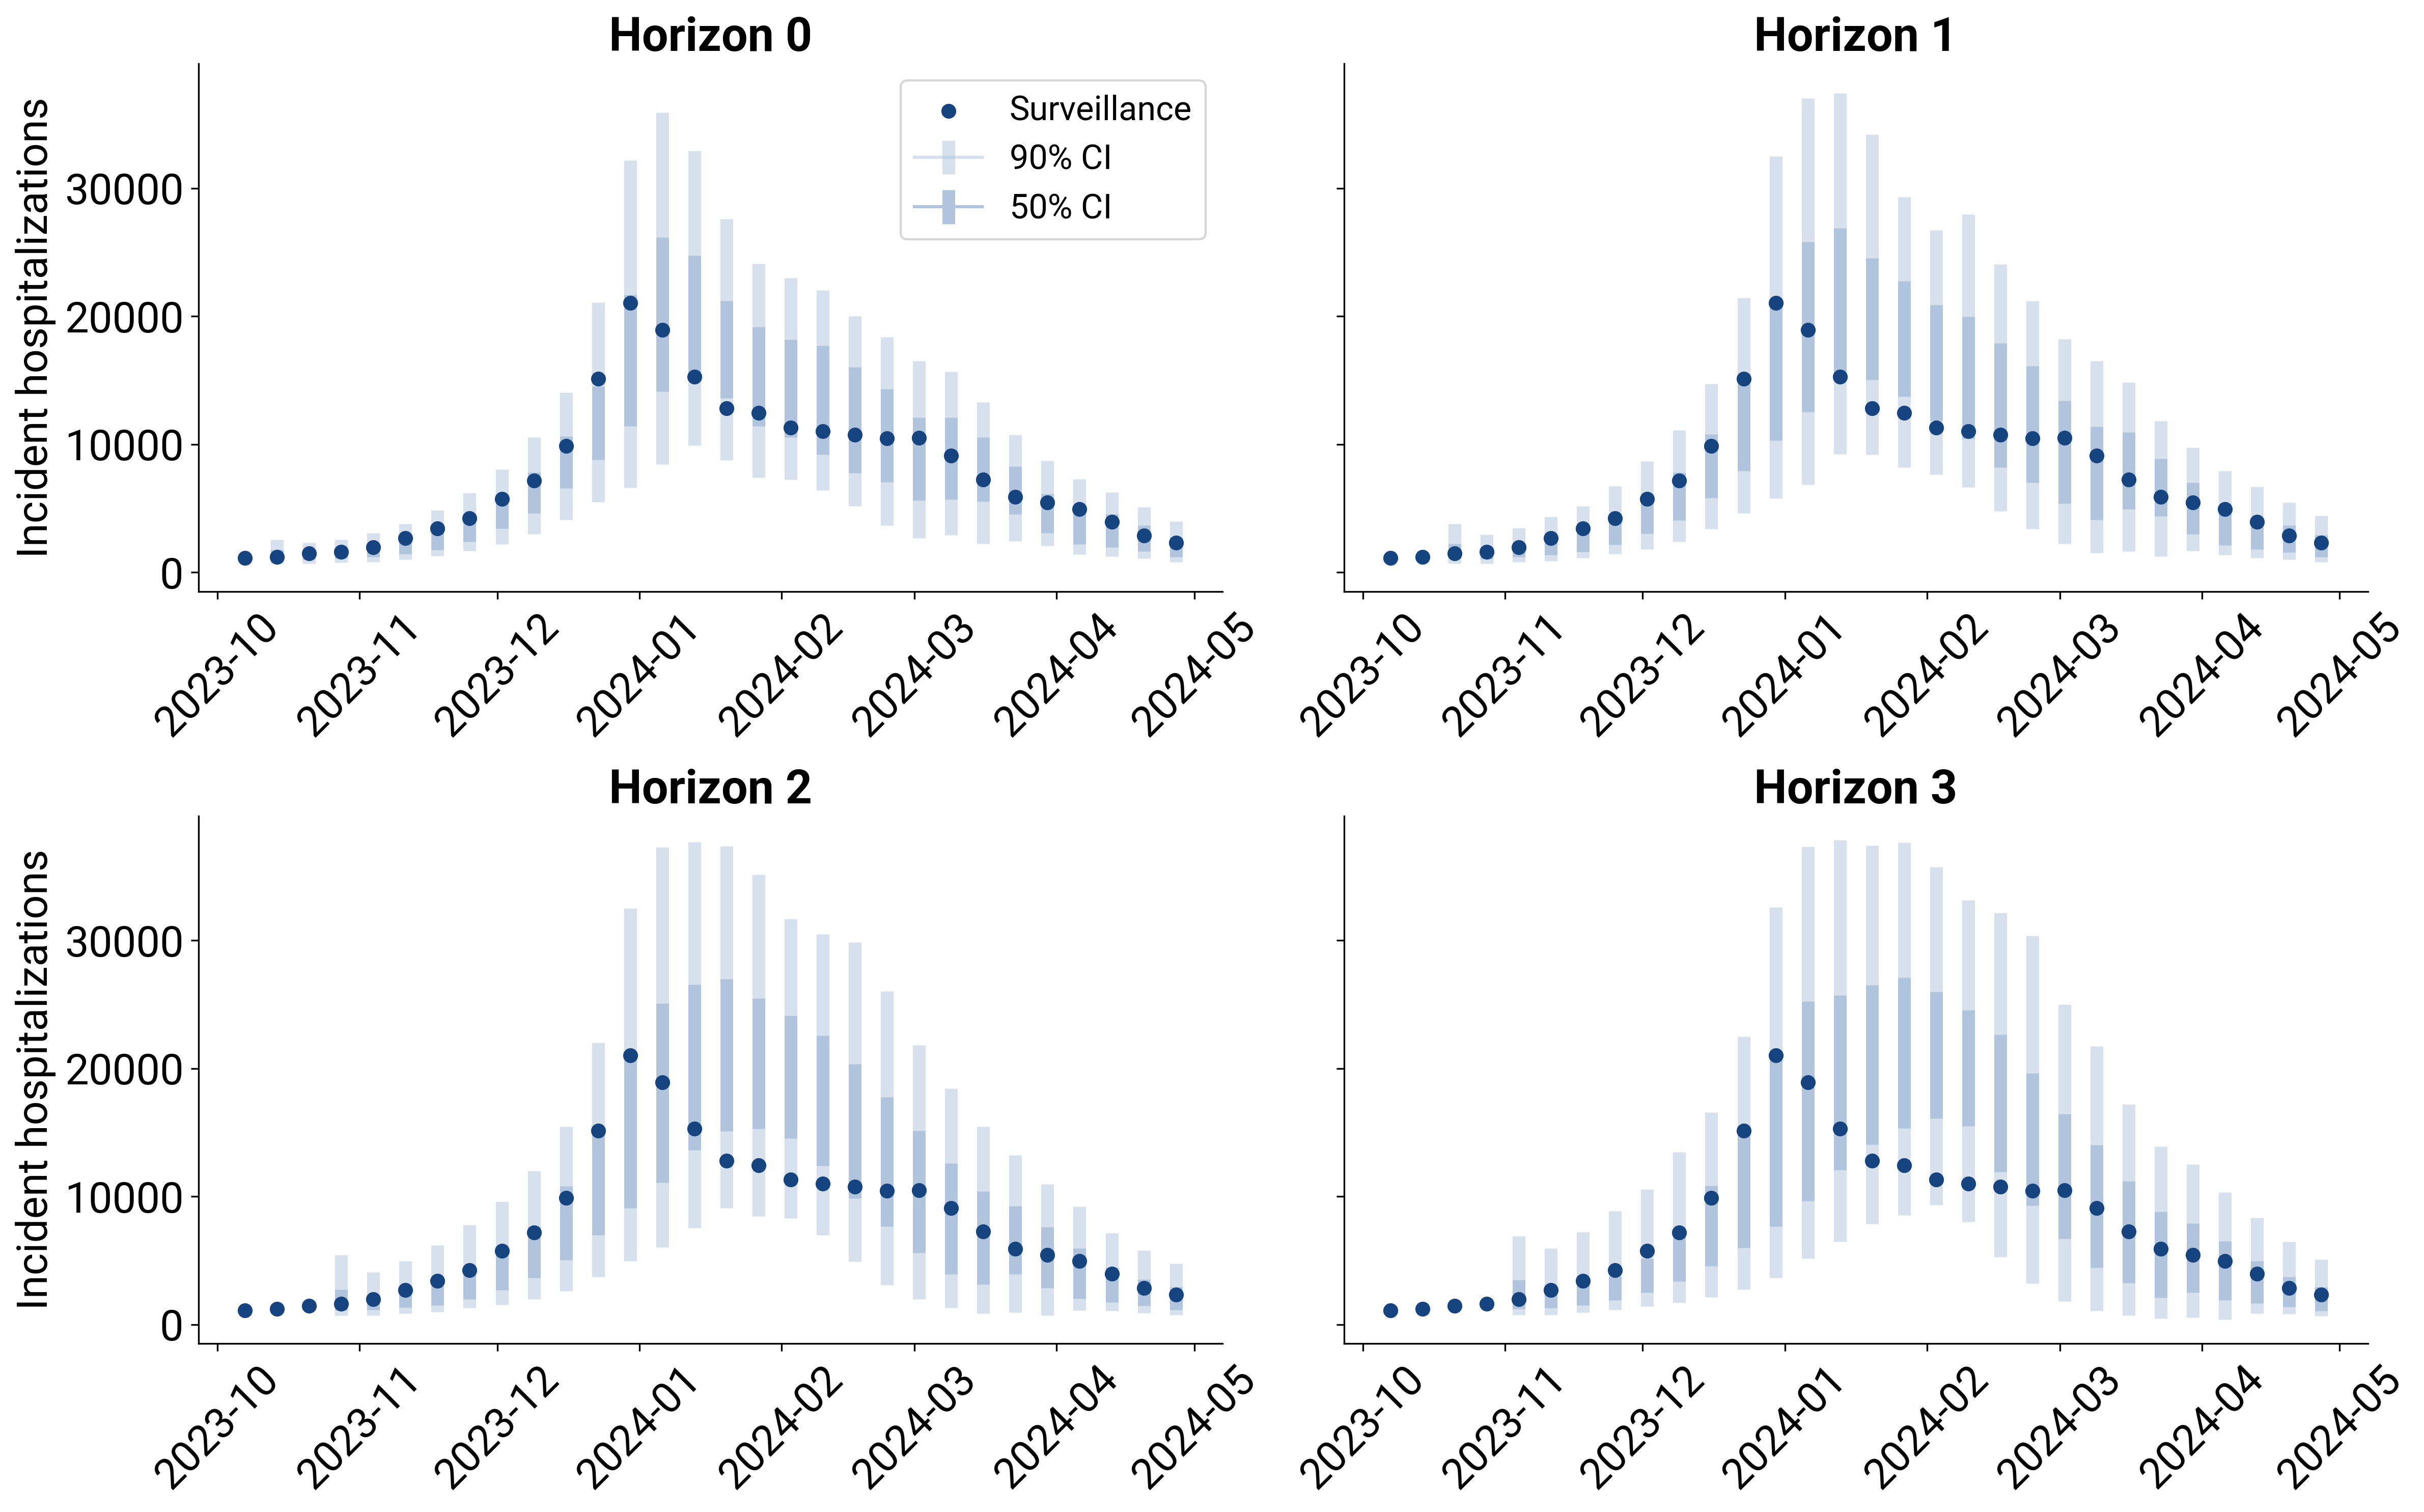

In [12]:
# Flags to control legend entries
shown_50 = False
shown_90 = False
surv = False

# Setup della figura
fig, axs = plt.subplots(2, 2, figsize=(16, 10), dpi=300, sharey=True)
axs = axs.ravel()

# Iterate through horizons
for horizon, ax in enumerate(axs):
    # Plot observed surveillance data
    ax.scatter(
        df_surv['date'],
        df_surv['hospitalizations'],
        color='#164480',
        label='Surveillance' if not surv else None,
        zorder=5
    )
    surv = True

    # Add forecast intervals for each round
    for round_number, df_round in dict_subm.items():
        if (horizon == 1 and round_number == 34) or \
           (horizon == 2 and round_number in [33, 34]) or \
           (horizon == 3 and round_number in [32, 33, 34]):
            continue

        df_h = df_round[df_round["horizon"] == horizon]
        df_h['output_type_id'] = df_h['output_type_id'].round(2)
        df_quantiles = df_h[df_h["output_type_id"].isin([0.05, 0.25, 0.75, 0.95, 0.50])]

        if not df_quantiles.empty:
            target_end_date = pd.to_datetime(df_quantiles["target_end_date"].values[0])
            median_value = df_quantiles[df_quantiles["output_type_id"] == 0.50]["value"].values[0]

            lower_90 = median_value - df_quantiles[df_quantiles["output_type_id"] == 0.05]["value"].values[0]
            upper_90 = df_quantiles[df_quantiles["output_type_id"] == 0.95]["value"].values[0] - median_value

            lower_50 = median_value - df_quantiles[df_quantiles["output_type_id"] == 0.25]["value"].values[0]
            upper_50 = df_quantiles[df_quantiles["output_type_id"] == 0.75]["value"].values[0] - median_value

            # 90% CI
            ax.errorbar(
                x=target_end_date,
                y=median_value,
                yerr=[[lower_90], [upper_90]],
                fmt='-',
                color='lightsteelblue',
                alpha=0.5,
                elinewidth=6,
                label='90% CI' if not shown_90 else None,
                markersize=7,
                markerfacecolor='#164480'
            )
            shown_90 = True

            # 50% CI
            ax.errorbar(
                x=target_end_date,
                y=median_value,
                yerr=[[lower_50], [upper_50]],
                fmt='-',
                color='lightsteelblue',
                alpha=0.99,
                elinewidth=6,
                label='50% CI' if not shown_50 else None,
                markersize=7,
                markerfacecolor='#164480'
            )
            shown_50 = True

    # Titles and labels
    ax.set_title(f"Horizon {horizon}", fontproperties=font_prop_title)
    ax.set_xlabel("", fontproperties=font_prop)

    if horizon in [0, 2]:
        ax.set_ylabel("Incident hospitalizations", fontproperties=font_prop)

    # Tick labels with font
    ax.tick_params(labelsize=15)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_prop)

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)

    # Clean look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Legend (only once)
    if horizon == 0:
        ax.legend(prop=font_prop_legend, loc='upper right')

# Layout adjustment
plt.tight_layout()
plt.savefig("../figures/forecasts_k25.png", dpi=300)
plt.show()


In [18]:
# Dictionary to store results: dict_subm[k][round]
dict_subm_k15_k50 = {}

for k in [0.15, 0.50]:
    k_perc = k*100
    dict_subm_k15_k50[k_perc] = {}
    for round in df_surv['horizon'].unique()[1:]:
        date = df_surv[df_surv['horizon'] == round]['date'].unique()[0]
        day_str = pd.to_datetime(date).strftime('%Y-%m-%d')
        path_adaptive = f"{adaptive_ensemble2_path}/{day_str}_{k}.csv"

        # Import and clean
        df_ens2 = import_ensemble2_forecast(path_adaptive, surv_lookup, horizon_to_date)
        df_ens2 = df_ens2.rename(columns={"quantiles": "output_type_id"})

        dict_subm_k15_k50[k_perc][round] = df_ens2

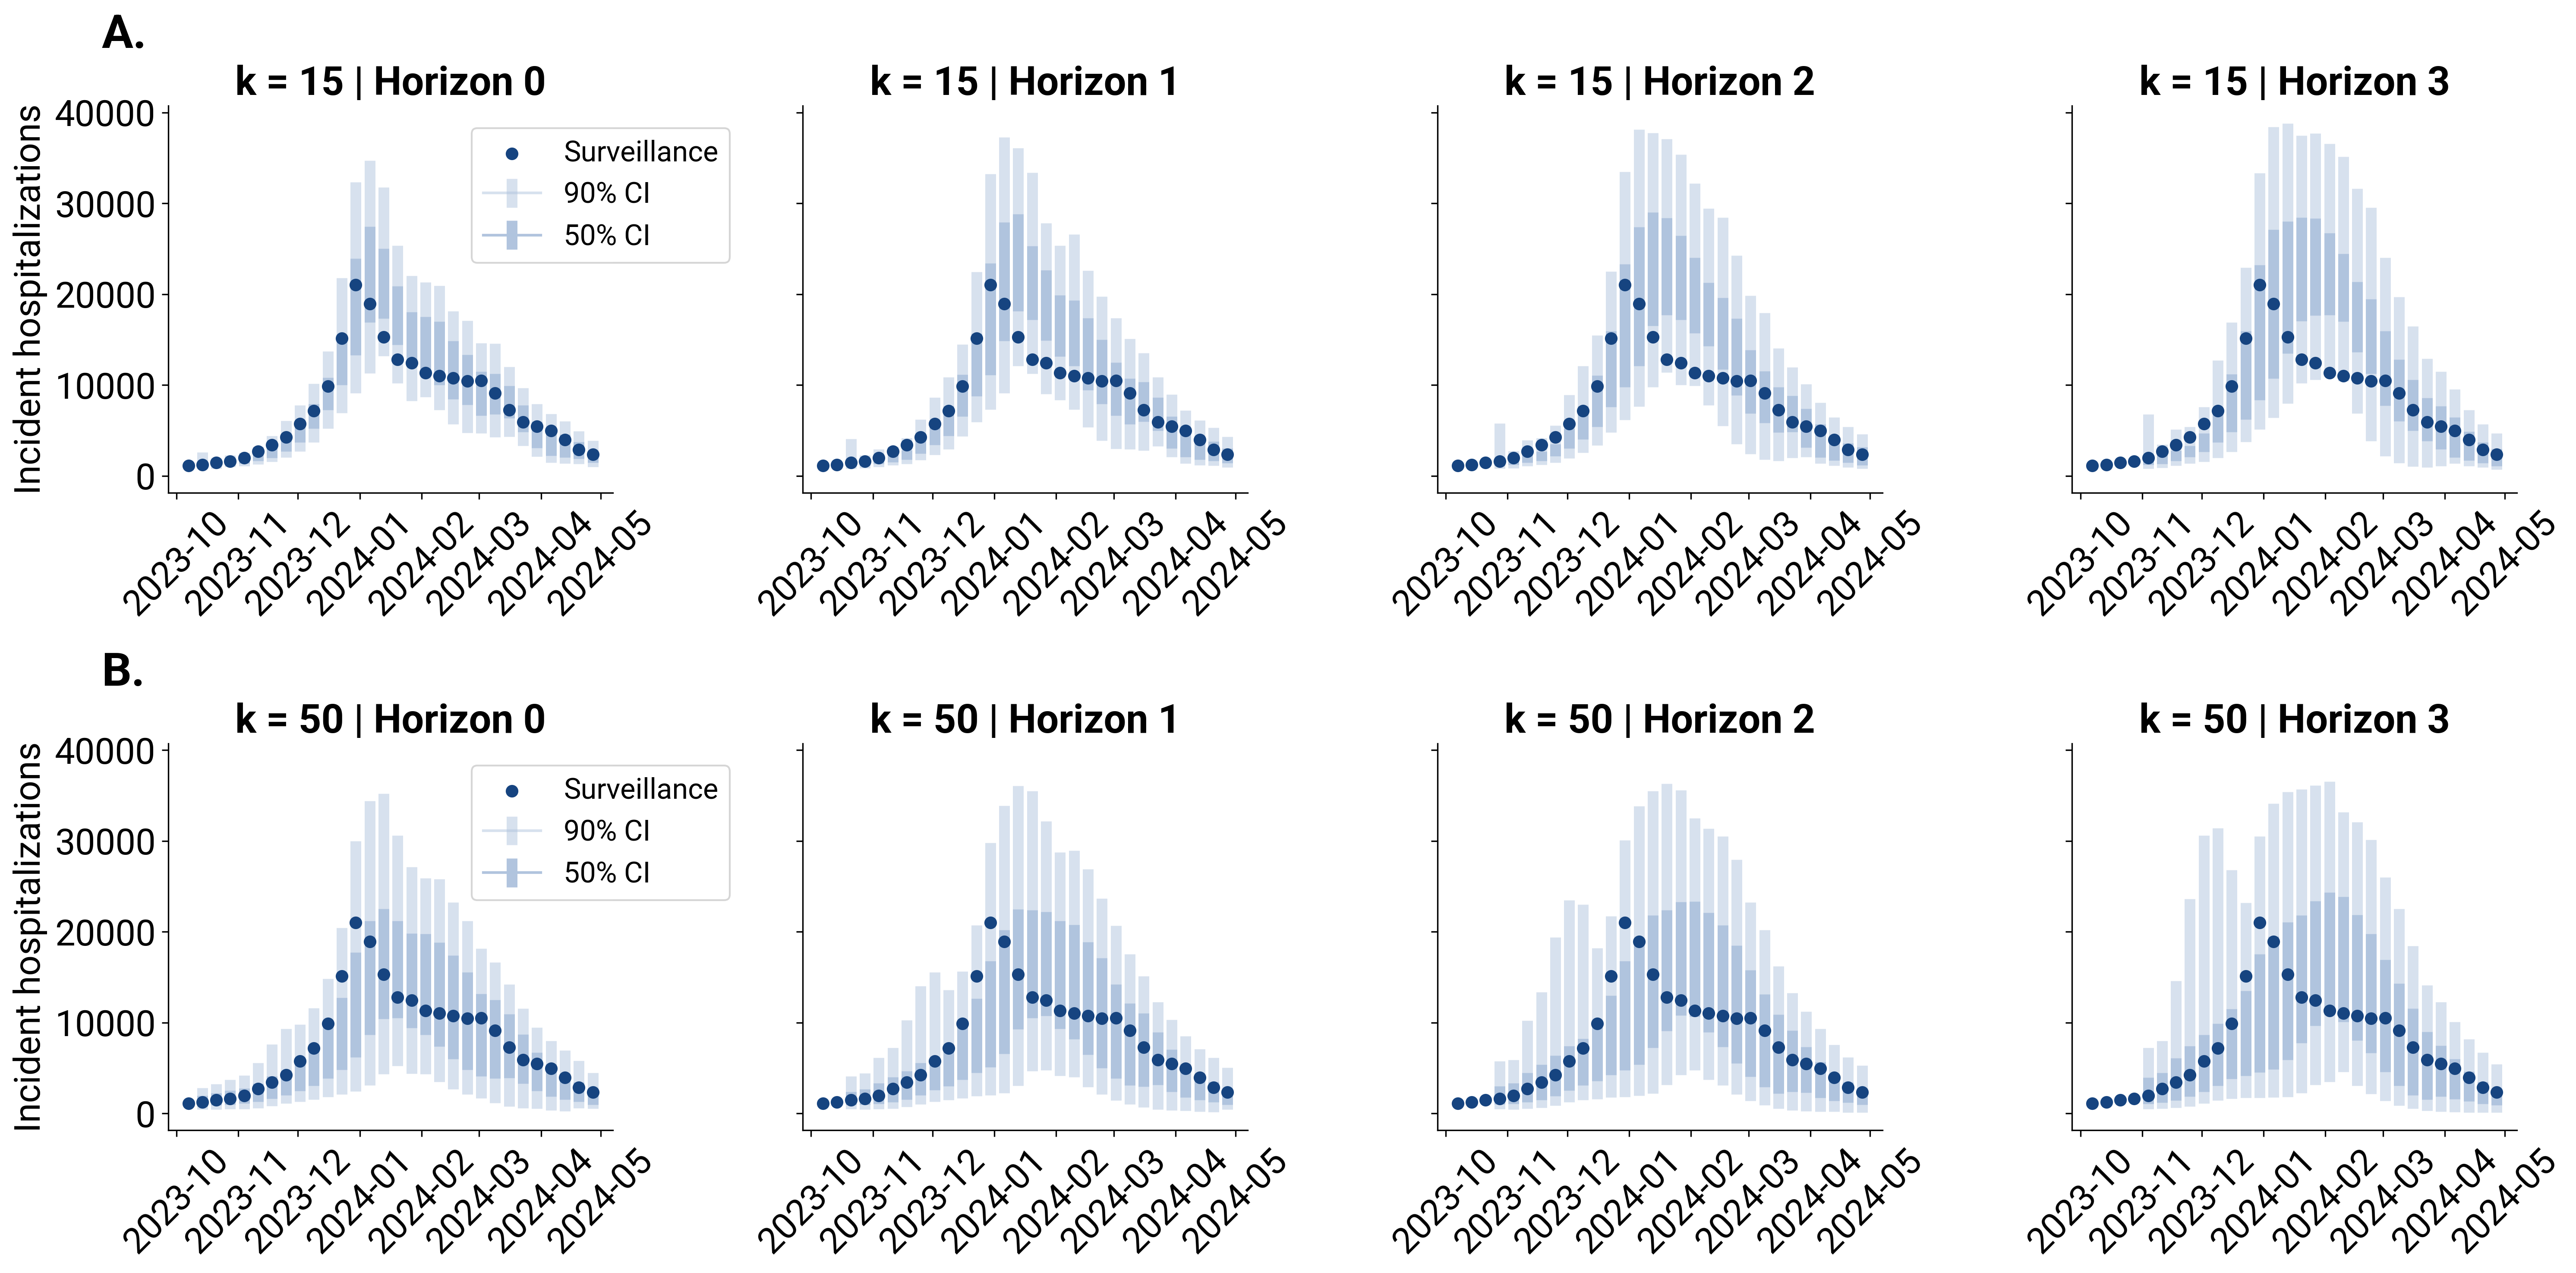

In [32]:
def plot_forecast_block(k_val, axs_block, block_label):
    shown_50 = False
    shown_90 = False
    surv = False

    for i, horizon in enumerate(range(4)):
        ax = axs_block[i]
        ax.scatter(
            df_surv['date'],
            df_surv['hospitalizations'],
            color='#164480',
            label='Surveillance' if not surv else None,
            zorder=5
        )
        surv = True
        dict_k_val = dict_subm_k15_k50[k_val]
        for round_number, df_round in dict_k_val.items():
            if (horizon == 1 and round_number == 34) or \
               (horizon == 2 and round_number in [33, 34]) or \
               (horizon == 3 and round_number in [32, 33, 34]):
                continue
            
            df_h = df_round[(df_round["horizon"] == horizon)]
            df_h['output_type_id'] = df_h['output_type_id'].round(2)
            df_quantiles = df_h[df_h["output_type_id"].isin([0.05, 0.25, 0.75, 0.95, 0.50])]

            if not df_quantiles.empty:
                target_end_date = pd.to_datetime(df_quantiles["target_end_date"].values[0])
                median = df_quantiles[df_quantiles["output_type_id"] == 0.50]["value"].values[0]

                lower_90 = median - df_quantiles[df_quantiles["output_type_id"] == 0.05]["value"].values[0]
                upper_90 = df_quantiles[df_quantiles["output_type_id"] == 0.95]["value"].values[0] - median

                lower_50 = median - df_quantiles[df_quantiles["output_type_id"] == 0.25]["value"].values[0]
                upper_50 = df_quantiles[df_quantiles["output_type_id"] == 0.75]["value"].values[0] - median

                # 90% CI
                ax.errorbar(
                    x=target_end_date,
                    y=median,
                    yerr=[[lower_90], [upper_90]],
                    fmt='-',
                    color='lightsteelblue',
                    alpha=0.5,
                    elinewidth=6,
                    label='90% CI' if not shown_90 else None,
                    markersize=7
                )
                shown_90 = True

                # 50% CI
                ax.errorbar(
                    x=target_end_date,
                    y=median,
                    yerr=[[lower_50], [upper_50]],
                    fmt='-',
                    color='lightsteelblue',
                    alpha=0.99,
                    elinewidth=6,
                    label='50% CI' if not shown_50 else None,
                    markersize=7
                )
                shown_50 = True
        ax.set_title(f"k = {k_val} | Horizon {horizon}", fontproperties=font_prop_title)
        if i in [0]:
            ax.set_ylabel("Incident hospitalizations", fontproperties=font_prop)
        else:
            ax.set_ylabel("")

        ax.tick_params(labelsize=15)
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_fontproperties(font_prop)

        ax.set_xlabel("")
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.tick_params(axis='x', rotation=45)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

        if i == 0:
            ax.legend(
        prop=font_prop_legend,
        loc='upper left',  # Start from inside the plot
        bbox_to_anchor=(0.65, 0.98),  # Slightly to the right within plot
    )
    axs_block[0].text(
        -0.15, 1.15, block_label, transform=axs_block[0].transAxes,
        fontsize=26, fontweight='bold', fontproperties=font_prop_title
    )

fig, axs = plt.subplots(2, 4, figsize=(20, 10), dpi=300, sharey=True)
axs = axs.ravel()
plot_forecast_block(k_val=15, axs_block=axs[:4], block_label='A.')
plot_forecast_block(k_val=50, axs_block=axs[4:], block_label='B.')

plt.tight_layout()
plt.savefig("../figures/forecasts_k15_k50")
plt.show()